# Propagacja wsteczna

In [31]:
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl        # plotting
from IPython.display import display, Image # display imported graphics

In [2]:
import os.path 

isdir = os.path.isdir('lib_nn') # check whether 'lib_nn' exists

if not isdir:
   !git clone https://github.com/bronwojtek/lib_nn.git # cloning the library from github

import sys                     
sys.path.append('./lib_nn') 

from neural import *            # importing my library package

Invoking __init__.py for neural


W tym rozdziale pokażemy szczegółowo, jak przeprowadzić uczenie nadzorowane dla klasyfikatorów wielowarstwowych omówionych w rozdziale {ref}`more-lab`. Ponieważ metoda opiera się na minimalizacji liczby błędnych odpowiedzi na próbce testowej, zaczynamy od dokładnego omówienia problemu minimalizacji błędów w naszej konfiguracji.

## Minimalizacja błędu 

Przypomnijmy, że w naszym przykładzie z punktami na płaszczyźnie z rozdziału {ref}`perc-lab` warunek dla różowych punktów był zadany przez nierówność

$w_0+w_1 x_1 + w_2 x_2 > 0$.

Wspomnieliśmy już pokrótce o klasie równoważności związanej z dzieleniem obu stron tej nierówności przez dodatnią stałą $c$. Ogólnie rzecz biorąc, co najmniej jedna z wag w powyższym warunku musi być niezerowa, aby był on nietrywialny. Załóżmy zatem, że $w_0 \neq 0$ (inne przypadki można potraktować analogicznie). Następnie podzielmy obie strony nierówności przez $|w_0|$, co daje

$$\frac{w_0}{|w_0|}+\frac{w_1}{|w_0|} \, x_1 + \frac{w_2}{|w_0|} \, x_2 > 0. $$

Wprowadzając notację $v_1=\frac{w_1}{w_0}$ and $v_2=\frac{w_2}{w_0}$, możemy zatem zapisać

$${\rm sgn}(w_0)( 1+v_1 \, x_1 +v_2 \, x_2) > 0,$$

gdzie znak ${\rm sgn}(w_0) = \frac{w_0}{|w_0|}$. Mamy więc w efekcie system dwuparametrowy (dla ustalonego znaku $w_0$).
 
Oczywiście przy pewnych wartościach $ v_1 $ i $ v_2 $ i dla danego punktu z próbki danych, perceptron poda w wyniku poprawną lub błędną odpowiedź. Naturalne jest zatem zdefiniowanie **funkcji błędu** $E$ w taki sposób, że dla każdego punktu $p$ próbki wnosi 1, jeśli odpowiedź jest niepoprawna, a 0, jeśli jest poprawna:


$$ E(v_1,v_2)=\sum_p \left\{ \begin{array}{ll} 1 -{\rm niepoprawna,~}\\ 0 -{\rm poprawna.} \end{array}\right .$$

$E$ ma zatem interpretację liczby źle sklasyfikowanych punktów. 

Możemy łatwo skonstruować tę funkcję w Pythonie:

In [3]:
def error(w0, w1 ,w2, sample, f=func.step):
    """
    error function for the perceptron (for 2-dim data with labels)
    
    inputs:
    w0, w1, w2 - weights
    sample - array of labeled data points p 
             p in an array in the format [x1, x1, label]
    f - activation function
    
    returns:
    error
    """
    er=0                                       # initial value of the error
    for i in range(len(sample)):               # loop over data points       
        yo=f(w0+w1*sample[i,0]+w2*sample[i,1]) # obtained answer
        er+=(yo-sample[i,2])**2
                      # sample[i,2] is the label
                      # adds the square of the difference of yo and the label
                      # this adds 1 if the answer is incorrect, and 0 if correct
    return er  # the error

Zastosowaliśmy tutaj małą sztuczkę, mając na uwadze przyszłe zastosowania. Oznaczając otrzymany wynik dla danego punktu danych jako $y_o^{(p)}$, a wynik prawdziwy (etykietę) jako $y_t^{(p)}$ (obydwa przyjmują wartości 0 lub 1), możemy zdefiniowane powyżej $E$ zapisać równoważnie jako


$$ E(v_1,v_2)=\sum_p \left ( y_o^{(p)}-y_t^{(p)}\right )^2,$$

co jest wzorem zaprogramowanym w kodzie. Rzeczywiście, kiedy $y_o^{(p)}=y_t^{(p)}$ (prawidłowa odpowiedź), wkład punktu wynosi 0, a kiedy $y_o^{(p)}\neq y_t^{(p) }$ (błędna odpowiedź), wkład wynosi $(\pm 1)^2=1$.

In [4]:
def point2():
    x1=np.random.random()          # random number from the range [0,1]
    x2=np.random.random()
    if(x2>x1*0.52+0.25):           # condition met
        return np.array([x1,x2,1]) # add label 1
    else:                          # not met
        return np.array([x1,x2,0]) # add label 0

Powtarzamy teraz symulacje z podrozdziału {ref}`perc-lab`, aby wygenerować etykietowaną próbkę danych **samp2** o 200 punktach (próbka jest utworzona z $w_0=-0.25$, $w_1=-0.52$ i $w_2=1$, co odpowiada $v_1=2.08$ i $v_2=-4$, przy czym ${\rm sgn}(w_0)=-1$).

In [5]:
samp2=np.array([point2() for _ in range(200)])              

Potrzebujemy teraz ponownie użyć algorytmu perceptronu z rozdz. {ref}`lab-pa`. W naszym szczególnym przypadku działa on na próbce dwuwymiarowych danych etykietowanych. Dla wygody, pojedyncza runda algorytmu może zostać zebrana w funkcję w następujący sposób:

In [6]:
def teach_perceptron(sample, eps, w_in, f=func.step):
    """
    Supervised learning for a single perceptron (single MCP neuron) 
    for a sample of 2-dim. labeled data
       
    input:
    sample - array of two-dimensional labeled data points p
             p is an array in the format [x1,x2,label]
             label = 0 or 1
    eps    - learning speed
    w_in   - initial weights in the format [[w0], [w1], [w2]]
    f      - activation function
    
    return: updated weights in the format [[w0], [w1], [w2]]
    """
    [[w0],[w1],[w2]]=w_in         # define w0, w1, and w2
    for i in range(len(sample)):  # loop over the whole sample
        for k in range(10):       # repeat 10 times  
            
            yo=f(w0+w1*sample[i,0]+w2*sample[i,1]) # output from the neuron, f(x.w)
            
            # update of weights according to the perceptron algorithm formula
            w0=w0+eps*(sample[i,2]-yo)*1
            w1=w1+eps*(sample[i,2]-yo)*sample[i,0]
            w2=w2+eps*(sample[i,2]-yo)*sample[i,1]
            
    return [[w0],[w1],[w2]]       # updated weights


Następnie prześledzimy działanie algorytmu perceptronu, obserwując jak modyfikuje on wartości wprowadzonej powyżej funkcji błędu $E(v_1,v_2)$. Zaczynamy od losowych wag, a następnie wykonujemy 10 rund zdefiniowanej powyżej funkcji **teach_perceptron**, wypisując zaktualizowane wagi i odpowiadający im błąd:

In [7]:
weights=[[func.rn()], [func.rn()], [func.rn()]] # initial random weights

print("Optimum:")
print("   w0  w1/w0  w2/w0 error")   # header

eps=0.7                 # initial learning speed
for r in range(10):     # rounds
    eps=0.8*eps         # decrease the learning speed
    weights=teach_perceptron(samp2,eps,weights,func.step) 
                        # see the top of this chapter
        
    w0_o=weights[0][0]  # updated weights and ratios
    v1_o=weights[1][0]/weights[0][0]
    v2_o=weights[2][0]/weights[0][0]
    
    print(np.round(w0_o,3),np.round(v1_o,3),np.round(v2_o,3),
          np.round(error(w0_o, w0_o*v1_o, w0_o*v2_o, samp2, func.step),0))             

Optimum:
   w0  w1/w0  w2/w0 error
-0.17 7.311 -13.855 40.0
-0.618 2.073 -3.999 0.0
-0.618 2.073 -3.999 0.0
-0.618 2.073 -3.999 0.0
-0.618 2.073 -3.999 0.0
-0.618 2.073 -3.999 0.0
-0.618 2.073 -3.999 0.0
-0.618 2.073 -3.999 0.0
-0.618 2.073 -3.999 0.0
-0.618 2.073 -3.999 0.0


Zauważamy, że w kolejnych rundach błąd stopniowo maleje (w zależności od symulacji, może czasem nieco podskoczyć, jeśli szybkość uczenia się jest zbyt duża, ale nie stanowi to problemu, o ile koniec końców możemy zejść do minimum), osiągając ostatecznie wartość bardzo małą lub dokładnie 0 (w zależności od konkretnego przypadku symulacji). W związku z tym
algorytm perceptronu, jak już widzieliśmy w rozdziale {ref}`perc-lab`, **minimalizuje błąd dla próbki treningowej**.


Pouczające jest spojrzenie na mapę konturową funkcji błędu $E(v_1, v_2)$ w pobliżu optymalnych parametrów:

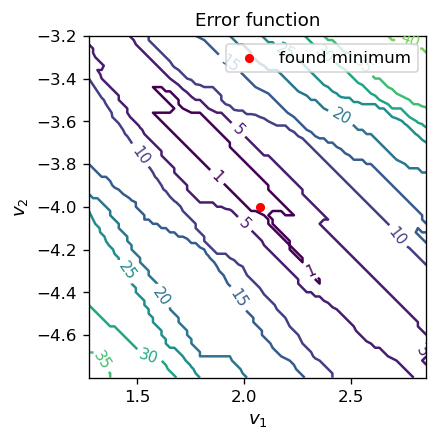

In [8]:
fig, ax = plt.subplots(figsize=(3.7,3.7),dpi=120)

delta = 0.02  # grid step in v1 and v2 for the contour map
ran=0.8       # plot range around (v1_o, v2_o)

v1 = np.arange(v1_o-ran,v1_o+ran, delta) # grid for v1
v2 = np.arange(v2_o-ran,v2_o+ran, delta) # grid for v2
X, Y = np.meshgrid(v1, v2)               # mesh for the contour plot

Z=np.array([[error(-1,-v1[i],-v2[j],samp2,func.step) 
             # we use the scaling property of the error function here 
             for i in range(len(v1))] for j in range(len(v2))]) # values of E(v1,v2) 

CS = ax.contour(X, Y, Z, [1,5,10,15,20,25,30,35,40,45,50])
                        # explicit contour level values
    
ax.clabel(CS, inline=1, fmt='%1.0f', fontsize=9) # contour label format

ax.set_title('Error function', fontsize=11)
ax.set_aspect(aspect=1)

ax.set_xlabel('$v_1$', fontsize=11)
ax.set_ylabel('$v_2$', fontsize=11)

ax.scatter(v1_o, v2_o, s=20,c='red',label='found minimum') # our found optimal point

ax.legend()
plt.show()

Uzyskane minimum znajduje się wewnątrz (lub blisko, w zależności od symulacji) wydłużonego obszaru w $v_1$ i $v_2$, gdzie błąd znika. 

## Ciągła funkcja aktywacji

Przyglądając się uważniej powyższej mapie konturowej, widzimy, że linie są „ząbkowane”. Dzieje się tak, ponieważ funkcja błędu, z oczywistego powodu, przyjmuje wartości całkowite. Jest zatem nieciągła, a zatem nieróżniczkowalna. Nieciągłości wynikają z nieciągłej funkcji aktywacji, mianowicie funkcji schodkowej. Mając na uwadze techniki, które poznamy niebawem, korzystne jest stosowanie funkcji aktywacji, która jest różniczkowalna. Historycznie tzw. **sigmoid**

$$ \sigma(s)=\frac{1}{1+e^{-s}}$$

był wykorzystywany w wielu praktycznych zastosowaniach dla ANN.

In [9]:
# sigmoid, a.k.a. the logistic function, or simply (1+arctanh(-s/2))/2 
def sig(s):
    return 1/(1+np.exp(-s))

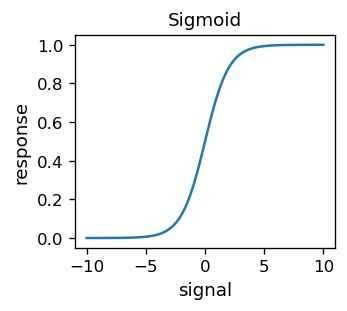

In [10]:
plt.show(draw.plot(sig,start=-10,stop=10,title='Sigmoid'))

Funkcja ta jest oczywiście różniczkowalna. Ponadto

$$ \sigma '(s) = \sigma (s) [1- \sigma (s)], $$

co jest szczególna własnością sigmoidu.

In [11]:
# derivative of sigmoid
def dsig(s):
     return sig(s)*(1-sig(s))

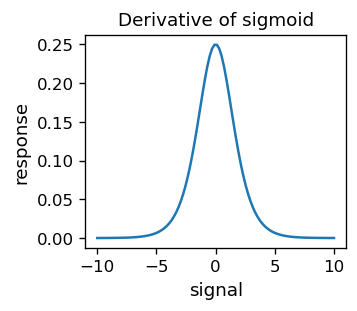

In [12]:
plt.show(draw.plot(dsig,start=-10,stop=10,title='Derivative of sigmoid'))

Wprowadza się również sigmoid z „temperaturą” $T $ (nomenklatura ta jest związana z podobnymi wyrażeniami dla funkcji termodynamicznych w fizyce):
$$\sigma(s;T)=\frac{1}{1+e^{-s/T}}.$$

In [13]:
# sigmoid with temperature T
def sig_T(s,T):
    return 1/(1+np.exp(-s/T))

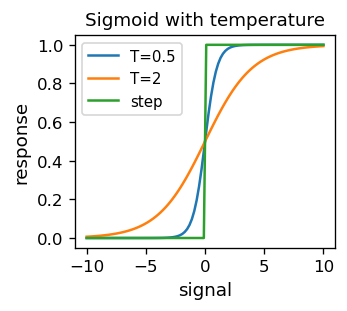

In [14]:
plt.figure(figsize=(2.8,2.3),dpi=120)

s = np.linspace(-10, 10, 100)

fs = [sig_T(z,.5) for z in s]
plt.plot(s, fs)
fs = [sig_T(z,2) for z in s]
plt.plot(s, fs)
fs = [func.step(z) for z in s]
plt.plot(s, fs)

plt.title("Sigmoid with temperature", fontsize=11)
plt.legend(('T=0.5','T=2','step'),fontsize=9)

plt.xlabel('signal',fontsize=11)
plt.ylabel('response',fontsize=11)
plt.show()


Dla coraz mniejszych $T$ sigmoid zbliża się do poprzednio używanej funkcji schodkowej.

Zauważ, że argumentem sigmoidu jest iloraz

$$
s/T = (w_0 + w_1 x_1 + w_2 x_2) / T = w_0 / T + w_1 / T \, x_1 + w_2 / T \, x_2 = \xi_0 + \xi_1 x_1 + \xi_2 x_2,
$$

co oznacza, że zawsze możemy przyjąć $T = 1$ bez utraty ogólności ($T $ to „skala”). Jednak teraz mamy trzy niezależne argumenty $ \xi_0 $, $ \xi_1 $ i $ \xi_2$, więc nie można zredukować obecnej sytuacji do tylko dwóch niezależnych parametrów, jak miało to miejsce w poprzednim podrozdziale.

Powtórzymy teraz nasz przykład z klasyfikatorem, ale z funkcją aktywacji daną przez sigmoid. Funkcja błędu

$$y_o^{(p)}=\sigma(w_0+w_1 x_1^{(p)} +w_2 x_2^{(p)}), $$

staje się teraz

$$E(w_0,w_1,w_2)=\sum_p \left [\sigma(w_0+w_1 x_1^{(p)} +w_2 x_2^{(p)})-y_t^{(p)} \right] ^2.$$

Algorytm perceptronu z funkcją aktywacji sigmoidu wykonujemy 1000 razy, wypisując co 100 krok:

In [15]:
weights=[[func.rn()],[func.rn()],[func.rn()]]      # random weights from [-0.5,0.5]

print("   w0   w1/w0  w2/w0 error")   # header

eps=0.7                       # initial learning speed
for r in range(1000):         # rounds
    eps=0.9995*eps            # decrease learning speed
    weights=teach_perceptron(samp2,eps,weights,func.sig) # update weights
    if r%100==99:
        w0_o=weights[0][0]               # updated weights 
        w1_o=weights[1][0] 
        w2_o=weights[2][0] 
        v1_o=w1_o/w0_o                   # ratios of weights
        v2_o=w2_o/w0_o
        print(np.round(w0_o,3),np.round(v1_o,3),np.round(v2_o,3),
              np.round(error(w0_o, w0_o*v1_o, w0_o*v2_o, samp2, func.sig),5))                             


   w0   w1/w0  w2/w0 error
-20.455 2.031 -3.99 0.98049
-26.414 1.977 -3.886 0.47767
-30.326 1.954 -3.844 0.36447
-33.282 1.94 -3.82 0.32368
-35.661 1.929 -3.805 0.30012
-37.646 1.921 -3.794 0.28081
-39.341 1.915 -3.787 0.26266
-40.814 1.909 -3.78 0.24521
-42.11 1.904 -3.775 0.22862
-43.263 1.899 -3.771 0.21313


Obserwujemy, zgodnie z oczekiwaniami, stopniowy spadek błędu w miarę postępu symulacji. Ponieważ funkcja błędu ma teraz trzy niezależne argumenty, nie można jej narysować w dwóch wymiarach. Możemy jednak pokazać jej rzut, np. dla ustalonej wartości $ w_0 $, co robimy poniżej:

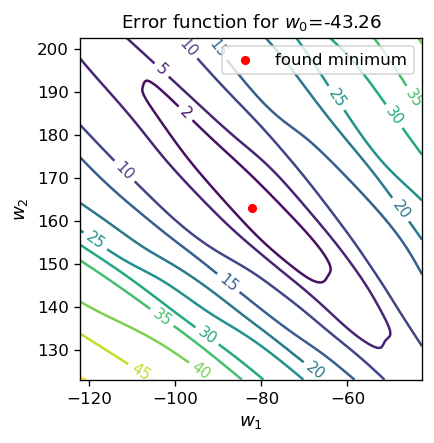

In [16]:
fig, ax = plt.subplots(figsize=(3.7,3.7),dpi=120)

delta = 0.5
ran=40 
r1 = np.arange(w1_o-ran, w1_o+ran, delta) 
r2 = np.arange(w2_o-ran, w2_o+ran, delta) 
X, Y = np.meshgrid(r1, r2) 

Z=np.array([[error(w0_o,r1[i],r2[j],samp2,func.sig) 
             for i in range(len(r1))] for j in range(len(r2))])  

CS = ax.contour(X, Y, Z,[0,2,5,10,15,20,25,30,35,40,45,50])
ax.clabel(CS, inline=1, fmt='%1.0f', fontsize=9)

ax.set_title('Error function for $w_0$='+str(np.round(w0_o,2)), fontsize=11)
ax.set_aspect(aspect=1)
ax.set_xlabel('$w_1$', fontsize=11)
ax.set_ylabel('$w_2$', fontsize=11)

ax.scatter(w1_o, w2_o, s=20,c='red',label='found minimum') # our found optimal point

ax.legend()
plt.show()

```{note}
W miarę jak wykonujemy coraz więcej iteracji, zauważamy, że wielkość wag rośnie, podczas gdy błąd naturalnie się zmniejsza. Powodem jest to, że nasza próbka danych jest separowalna, więc w przypadku użycia schodkowej funkcji aktywacji możliwe jest rozdzielenie próbki linią podziału i zejście z błędem aż do zera. W przypadku sigmoidu, zawsze istnieje pewien (niewielki) wkład do błędu, ponieważ wartości funkcji mieszczą się w sposób ciągły w przedziale (0,1). Jak omówiliśmy powyżej, w sigmoidzie, którego argumentem jest $ (w_0 + w_1 x_1 + w_2 x_2) / T$, zwiększanie wag jest równoznaczne ze zmniejszaniem temperatury $T$. W moare postępu symulacji sigmoid zbliża się zatem do funkcji schodkowej, a błąd dąży do zera. Zachowanie to jest widoczne w powyższych symulacjach.
```

## Najstromszy spadek

Powodem dla powyższych symulacji było doprowadzenie czytelnika do wniosku, że zagadnienie optymalizacji wag można sprowadzić do ogólnego problemu minimalizacji funkcji wielu zmiennych. Jest to standardowy (choć na ogół trudny) problem w analizie matematycznej i metodach numerycznych. Problemy związane ze znalezieniem minimum funkcji wielu zmiennych są dobrze znane:

- mogą istnieć minima lokalne, dlatego znalezienie minimum globalnego może być bardzo trudne;

- minimum może być w nieskończoności (czyli matematycznie nie istnieć);

- Funkcja wokół minimum może być bardzo płaska, tj. jej gradient jest bardzo mały. Wówczas znajdowanie minimum z pomocą metod gradientowych jest bardzo powolne;

Ogólnie rzecz biorąc, minimalizacja numeryczna funkcji to sztuka! Opracowano tu wiele metod, a właściwy dobór do danego problemu ma kluczowe znaczenie dla sukcesu. Poniżej zastosujemy najprostszy wariant, tzw. metodę **najstromszego spadku**.

Dla różniczkowalnej funkcji wielu zmiennych $ F (z_1, z_2, ..., z_n) $, lokalnie najbardziej strome nachylenie jest okreslone przez minus gradient funkcji $ F $,
$$-\left (\frac{\partial F}{\partial z_1}, \frac{\partial F}{\partial z_2}, ..., 
\frac{\partial F}{\partial z_n} \right ), $$

gdzie pochodne cząstkowe definiuje się jako granice

$$\frac{\partial F}{\partial z_1} = \lim _ {\Delta \to 0} \frac {F (z_1 + \Delta, z_2, ..., z_n) -F (z_1, z_2, ..., z_n)} { \Delta } $$

i podobnie dla pozostałych $ z_i $.

Metoda znajdowania minimum funkcji poprzez najstromszy spadek zadana jest przez algorytm iteracyjny, w którym aktualizujemy współrzędne (wyszukiwanego minimum) w każdym kroku iteracji $m$ (górny wskaźnik) w nastepujacy sposób:

$$z_{i}^{(m+1)} = z_i^{(m)} - \epsilon  \, \frac{\partial F}{\partial z_i}. $$ 

W naszym zagadnieniu potrzebujemy zminimalzować funcję błedu 

$$E(w_0,w_1,w_2)= \sum_p [y_o^{(p)}-y_t^{(p)}]^2=\sum_p [\sigma(s^{(p)})-y_t^{(p)}]^2=\sum_p [\sigma(w_0  x_0^{(p)}+w_1 x_1^{(p)} +w_2 x_2^{(p)})-y_t^{(p)}]^2. $$

Aby obliczyć pochodne, stosujemy **twierdzenie o pochodnej funkcji złożonej**. 

```{admonition} Tw. o pochodnej funkcji złożonej

Dla funkcji złożonej

$[f(g(x))]' = f'(g(x)) g'(x)$.

Dla złożenia większej liczby funkcji $[f(g(h(x)))]' = f'(g(h(x))) \,g'(h(x)) \,h'(x)$ itp. 
```

Prowadzi to do wzoru 

$$ \frac{\partial E}{\partial w_i} = \sum_p 2[\sigma(s^{(p)})-y_t^{(p)}]\, \sigma'(s^{(p)}) \,x_i^{(p)} = \sum_p 2[\sigma(s^{(p)})-y_t^{(p)}]\, \sigma(s^{(p)})\, [1-\sigma(s^{(p)})] \,x_i^{(p)}$$

(pochodna funkcji kwadratowej $ \times $ pochodna sigmoidu $ \times $ pochodna $ s ^ {(p)} $), gdzie w ostatniej równości użyliśmy specjalnej własności pochodnej sigmoidu. Metoda najstromszego spadku aktualizuje zatem wagi w następujący sposób:

$$w_i \to w_i - \varepsilon (y_o^{(p)} -y_t^{(p)}) y_o^{(p)} (1-y_o^{(p)}) x_i.$$

Zauważmy, że aktualizacja zawsze występuje, ponieważ odpowiedź $ y_o^ {(p)} $ nigdy nie jest ściśle równa 0 lub 1, podczas gdy
prawdziwa wartość (etykieta) $ y_t ^ {(p)} $ wynosi 0 lub 1.

Ponieważ $ y_o ^ {(p)} (1-y_o ^ {(p)}) = \sigma (s ^ {(p)}) [1- \sigma (s ^ {(p)})] $ jest istotnie różne od zera tylko w okolicy $ s ^ {(p)} = 0$ (patrz wcześniejszy wykres pochodnej sigmoidu), znacząca aktualizacja następuje tylko w pobliżu progu. To cecha jest odpowiednia, ponieważ problemy z błędną klasyfikacją zdarzają się właśnie w pobliżu linii podziału.

``` {note}
Dla porównania, wcześniejszy algorytm perceptronu jest strukturalnie bardzo podobny,

$$w_i \to w_i - \varepsilon \,(y_o^{(p)} - y_t^{(p)}) \, x_i,$$

ale tutaj aktualizacja następuje dla wszystkich punktów próbki, a nie tylko tych w pobliżu linii podziału.
```

Kod algorytmu uczenia naszego perceptronu metodą najstromszyego spadku jest następujący:

In [17]:
def teach_sd(sample, eps, w_in): # Steepest descent for the perceptron
    
    [[w0],[w1],[w2]]=w_in              # initial weights
    for i in range(len(sample)):       # loop over the data sample
        for k in range(10):            # repeat 10 times 
            
            yo=func.sig(w0+w1*sample[i,0]+w2*sample[i,1])  # obtained answer for pont i

            w0=w0+eps*(sample[i,2]-yo)*yo*(1-yo)*1            # update of weights
            w1=w1+eps*(sample[i,2]-yo)*yo*(1-yo)*sample[i,0]
            w2=w2+eps*(sample[i,2]-yo)*yo*(1-yo)*sample[i,1]
    return [[w0],[w1],[w2]]

Jego wydajność jest podobna do oryginalnego algorytmu perceptronu badanego powyżej:

In [18]:
weights=[[func.rn()],[func.rn()],[func.rn()]]      # random weights from [-0.5,0.5]

print("   w0   w1/w0  w2/w0 error")   # header

eps=0.7                       # initial learning speed
for r in range(1000):         # rounds
    eps=0.9995*eps            # decrease learning speed
    weights=teach_sd(samp2,eps,weights) # update weights
    if r%100==99:
        w0_o=weights[0][0]               # updated weights 
        w1_o=weights[1][0] 
        w2_o=weights[2][0] 
        v1_o=w1_o/w0_o
        v2_o=w2_o/w0_o
        print(np.round(w0_o,3),np.round(v1_o,3),np.round(v2_o,3),
              np.round(error(w0_o, w0_o*v1_o, w0_o*v2_o, samp2, func.sig),5))                                          

   w0   w1/w0  w2/w0 error
-10.24 1.982 -3.94 1.87852
-13.273 1.946 -3.859 1.28437
-15.273 1.932 -3.831 1.04334
-16.788 1.923 -3.815 0.90363
-18.011 1.916 -3.804 0.80881
-19.035 1.91 -3.796 0.73887
-19.913 1.904 -3.79 0.68469
-20.678 1.899 -3.784 0.64135
-21.352 1.895 -3.78 0.60589
-21.953 1.892 -3.776 0.57636


Podsumowując dotychczasowy materiał, wykazaliśmy, że można skutecznie uczyć jednowarstwy perceptron (pojedynczy neuronu MCP) za pomocą metody najstromszego spadku, minimalizując funkcję błędu generowaną przez badaną próbkę. W następnym podrozdziale uogólnimy ten pomysł na dowolny wielowarstwową sieć typu feed-forward. 

(bpa-lab)=
## Algorytm propagacji wstecznej (backprop)

Materiał tego podrozdziału jest absolutnie **kluczowy** dla zrozumienia idei uczenia sieci neuronowych poprzez uczenie nadzorowane. Jednocześnie dla czytelnika mniej zaznajomionego z analizą matematyczną może być dość trudny, ponieważ pojawiają się wyprowadzenia i wzory z bogatą notacją. Nie udało się jednak znaleźć sposobu na przedstawienie materiału w prostszy sposób niż poniżej, z jednoczesnym zachowaniem niezbędnego rygoru.


```{note}

Formuły, które wyprowadzamy tutaj krok po kroku, stanowią słynny **algorytm wstecznej propagacji (backprop)** {cite}`bryson1969` dla aktualizacji wag perceptronu wielowarstwowego. Wykorzystujemy tylko dwa podstawowe fakty:

- **tw. o pochodnej funkcji złożonej** do obliczania pochodnej, oraz
- **metodę najstromszego spadku**, wyjaśnioną w poprzednim podrozdziale.
```

Rozważmy perceptron z dowolną liczbą warstw neuronowych, $l$. Neurony w warstwach pośrednich $j=1,\dots,l-1$ są ponumerowane odpowiednimi wskaźnikami $\alpha_j=0,\dots,n_j$, gdzie 0 oznacza węzeł progowy. W warstwie wyjściowej, nie zawierającej węzła progowego, wskaźnik przyjmuje wartości $\alpha_l=1,\dots,n_l$. Na przykład sieć z wykresu poniżej ma

$$l=4, \; \; \alpha_1=0,\dots,4, \;\; \alpha_2=0,\dots,5, \;\; \alpha_3=0,\dots,3, \;\; \alpha_4=1,\dots,2,$$

ze wskaźnikami w każdej warstwie liczonymi od dołu.

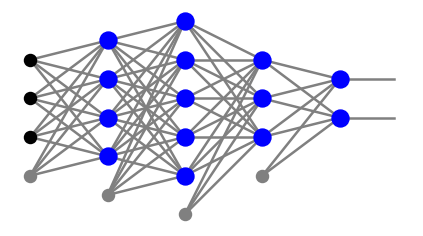

In [19]:
plt.show(draw.plot_net([3,4,5,3,2]))

Funkcja błędu to suma po punktach próbki treningowej oraz dodatkowo po węzłach w warstwie wyjściowej:

$$
E(\{w\})=\sum_p \sum_{\alpha_l=1}^{n_l} \left[ y_{o,{\alpha_l}}^{(p)}(\{w\})-y_{t,{\alpha_l}}^{(p)}\right]^2,
$$ 

gdzie $ \{w \} $ reprezentują wszystkie wagi sieci.
Pojedynczy wkład punktu $p$ do $E$, oznaczony jako $e$, to
suma po wszystkich neuronach w warstwie wyjściowej:

$$
e(\{w\})= \sum_{{\alpha_l}=1}^{n_l}\left[ y_{o,{\alpha_l}}-y_{t,{\alpha_l}}\right]^2. 
$$

Dla zwięzłości, opuściliśmy górny wskaźnik $(p)$.
Dla neuronu $\alpha_j$ w warstwie $j$ sygnałem wejściowym jest

$$
s_{\alpha_j}^{j}=\sum_{\alpha_{j-1}=0}^{n_{j-1}} x_{\alpha_{j-1}}^{j-1} w_{\alpha_{j-1} \alpha_j}^{j}.
$$

Sygnały w warstwie wyjściowej mają postać

$$
y_{o,{\alpha_l}}=f\left( s_{\alpha_l}^{l} \right)
$$


natomiast sygnały wyjściowe w warstwach pośrednich $j=1,\dots,l-1$ to

$$
x_{\alpha_j}^{j}=f \left ( s_{\alpha_j}^{j}\right ),\;\;\;\alpha_{j}=1,\dots,n_j, \;\; \; {\rm i} \;\;\; x_0^{j}=1,
$$

z węzłem progowym mającym wartość 1.

Kolejne podstawienia powyższych formuł do $e$ są następujące:

$e = \sum_{{\alpha_l}=1}^{n_l}\left( y_{o,{\alpha_l}}-y_{t,{\alpha_l}}\right)^2$

$=\sum_{{\alpha_l}=1}^{n_l} \left( f \left (\sum_{\alpha_{l-1}=0}^{n_{l-1}} x_{\alpha_{l-1}}^{l-1} w_{\alpha_{l-1} {\alpha_l}}^{l} \right )-y_{t,{\alpha_l}} \right)^2$

$=\sum_{{\alpha_l}=1}^{n_l} \left( 
f \left (\sum_{\alpha_{l-1}=1}^{n_{l-1}} f \left( \sum_{\alpha_{l-2}=0}^{n_{l-2}} x_{\alpha_{l-2}}^{l-2} w_{\alpha_{l-2} \alpha_{l-1}}^{l-1}\right) w_{\alpha_{l-1} {\alpha_l}}^{l} + x_0^{l-1} w_{0 \gamma}^{l} \right)-y_{t,{\alpha_l}} \right)^2$

$=\sum_{{\alpha_l}=1}^{n_l} \left( 
f \left (\sum_{\alpha_{l-1}=1}^{n_{l-1}} f\left( 
\sum_{\alpha_{l-2}=1}^{n_{l-2}} f\left( \sum_{\alpha_{l-3}=0}^{n_{l-3}} x_{\alpha_{l-3}}^{l-3} w_{\alpha_{l-3} \alpha_{l-2}}^{l-2}\right) w_{\alpha_{l-2} \alpha_{l-1}}^{l-1} + 
x_{0}^{l-2} w_{0 \alpha_{l-1}}^{l-1}
 \right)  w_{\alpha_{l-1} {\alpha_l}}^{l} + x_0^{l-1} w_{0 {\alpha_l}}^{l} \right)-y_{t,{\alpha_l}} \right)^2$

$=\sum_{{\alpha_l}=1}^{n_l} \left( 
f \left (\sum_{\alpha_{l-1}=1}^{n_{l-1}} f\left( 
\dots f\left( \sum_{\alpha_{0}=0}^{n_{0}} x_{\alpha_{0}}^{0} w_{\alpha_{0} \alpha_{1}}^{1}\right) w_{\alpha_{1} \alpha_{2}}^{2} + 
x_{0}^{1} w_{0 \alpha_{2}}^{2} \dots
 \right)  w_{\alpha_{l-1} {\alpha_l}}^{l} + x_0^{l-1} w_{0 {\alpha_l}}^{l} \right)-y_{t,{\alpha_l}} \right)^2$

Obliczając kolejne pochodne względem wag idąc wstecz, tj. od $j=l$ do 1, otrzymujemy (patrz ćwiczenia)

$$
\frac{\partial e}{\partial w^j_{\alpha_{j-1} \alpha_j}} = x_{\alpha_{j-1}}^{j-1} D_{\alpha_j}^{j} , \;\;\; \alpha_{j-1}=0,\dots,n_{j-1}, \;\; \alpha_{j}=1,\dots,n_{j},
$$ 

gdzie

$D_{\alpha_l}^{l}=2 (y_{o,\alpha_l}-y_{t,\alpha_l})\, f'(s_{\alpha_l}^{l})$,

$D_{\alpha_j}^{j}= \sum_{\alpha_{j+1}} D_{\alpha_{j+1}}^{j+1}\, w_{\alpha_j \alpha_{j+1}}^{j+1} \, f'(s_{\alpha_j}^{j}), ~~~~ j=l-1,l-2,\dots,1$.

Ostatnie wyrażenie to rekurencja wstecz. Zauważamy, że aby uzyskać $D^j$, potrzebujemy $D^{j+1}$, które uzyskaliśmy już w poprzednim kroku, oraz sygnał $s^j$, który znamy z propagacji sygnału do przodu. Ta rekurencja prowadzi do uproszczenia oblicznai pochodnych i aktualizacji wag.

Przy najstromszym spadku wagi są aktualizowane jako

$$ w^j_{\alpha_{j-1} \alpha_j} \to  w^j_{\alpha_{j-1} \alpha_j} -\varepsilon x_{\alpha_{j-1}}^{j-1} D_{\alpha_j}^{j}, $$ 

W przypadku sigmoidu możemy użyć

$$
\sigma'(s_A^{(i)})=\sigma'(s_A^{(i)}) (1-\sigma'(s_A^{(i)})) =x_A^{(i)}(1-x_A^{(i)}).
$$

```{note}

Powyższe formuły wyjaśniają nazwę **propagacja wsteczna**, ponieważ w aktualizacji wag zaczynamy od ostatniej warstwy, a następnie posuwamy się rekurencyjnie do początku sieci. Na każdym kroku potrzebujemy tylko sygnału w danej warstwie i właściwości kolejnej warstwy! Te cechy wynikają z
1)  charakteru feed-forward sieci oraz
2) tw. o pochodnej funkcji złożonej.
```

```{important}

Praktyczne znaczenie cofania się warstwa po warstwie polega na tym, że w jednym kroku aktualizuje się znacznie mniej wag: tylko te, które wchodzą do danej warstwy, a nie wszystkie naraz. Ma to znaczenie dla zbieżności metody najstromszego spadku, zwłaszcza dla sieci głębokich (o wielu warswach).
```

Jeżeli funkcje aktywacji są różne w różnych warstwach (oznaczamy je $f_j$ dla warstwy $j$), to zachodzi oczywista modyfikacja:

$D_{\alpha_l}^{l}=2 (y_{o,\alpha_l}-y_{t,\alpha_l})\, f_l'(s_{\alpha_l}^{l})$, 

$D_{\alpha_j}^{j}= \sum_{\alpha_{j+1}} D_{\alpha_{j+1}}^{j+1}\, w_{\alpha_j \alpha_{j+1}}^{j+1} \, f_j'(s_{\alpha_j}^{j}), ~~~~ j=l-1,l-2,\dots,1$. 

Nie jest to rzadkie, ponieważ w wielu zastosowaniach wybiera się różne funkcje aktywacji dla warstw pośrednich i warswy wyjściowej.

### Kod dla algorytmu backprop

Następnie przedstawimy prosty kod realizujący algorytm backprop. Jest to bezpośrednia implementacja wyprowadzonych powyżej formuł. W kodzie zachowujemy jak najwięcej notacji z powyższego wyprowadzenia.

Kod ma tylko 12 linijek, nie licząc komentarzy!

In [20]:
def back_prop(fe,la, p, ar, we, eps,f=func.sig,df=func.dsig):
    """
    fe - array of features
    la - array of labels
    p  - index of the used data point
    ar - array of numbers of nodes in subsequent layers
    we - disctionary of weights
    eps - learning speed 
    f   - activation function
    df  - derivaive of f
    """
 
    l=len(ar)-1 # number of neuron layers (= index of the output layer)
    nl=ar[l]    # number of neurons in the otput layer  
   
    x=func.feed_forward(ar,we,fe[p],ff=f) # feed-forward of point p
   
    # formulas from the derivation in a one-to-one notation:
    
    D={}                 
    D.update({l: [2*(x[l][gam]-la[p][gam])*
                    df(np.dot(x[l-1],we[l]))[gam] for gam in range(nl)]})   
    we[l]-=eps*np.outer(x[l-1],D[l]) 
    
    for j in reversed(range(1,l)):           
        u=np.delete(np.dot(we[j+1],D[j+1]),0) 
        v=np.dot(x[j-1],we[j])          
        D.update({j: [u[i]*df(v[i]) for i in range(len(u))]}) 
        we[j]-=eps*np.outer(x[j-1],D[j])      

(circ-lab)=
## Przykład z kołem

Kod ilustrujemy na przykładzie klasyfikatora binarnego punktów wewnątrz okręgu.

In [21]:
def cir():
    x1=np.random.random()                  # coordinate 1
    x2=np.random.random()                  # coordinate 2
    if((x1-0.5)**2+(x2-0.5)**2 < 0.4*0.4): # inside circle, radius 0.4, center (0.5,0.5)
        return np.array([x1,x2,1])
    else:                                  # outside
        return np.array([x1,x2,0])


Do przyszłego użytku **(nowa konwencja)** podzielimy próbkę na oddzielne tablice **cech** (dwie współrzędne) i **etykiet** (1, jeśli punkt znajduje się wewnątrz okręgu, 0 w przeciwnym razie):

In [22]:
sample_c=np.array([cir() for _ in range(3000)]) # sample
features_c=np.delete(sample_c,2,1)
labels_c=np.delete(np.delete(sample_c,0,1),0,1)

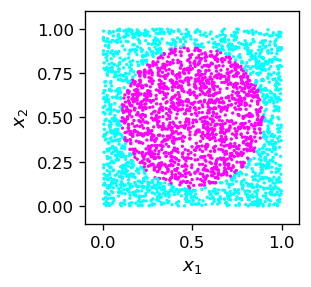

In [23]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(sample_c[:,0],sample_c[:,1],c=sample_c[:,2],
            s=1,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

Dobieramy następującą architekturę i początkowe parametry:

In [24]:
arch_c=[2,4,4,1]                  # architecture
weights=func.set_ran_w(arch_c,4)  # scaled random initial weights in [-2,2]
eps=.7                            # initial learning speed 

Symulacja zabiera kilka minut. 

In [25]:
for k in range(1000):   # rounds
    eps=.995*eps       # decrease learning speed
    if k%100==99: print(k+1,' ',end='')             # print progress        
    for p in range(len(features_c)):                # loop over points
        func.back_prop(features_c,labels_c,p,arch_c,weights,eps,
                       f=func.sig,df=func.dsig) # backprop

100  200  300  400  500  600  700  800  900  1000  

Zmniejszenie szybkości uczenia się w każdej rundzie daje końcową wartość $\varepsilon$, która powinna być niewielka, ale nie za mała:

In [26]:
eps

0.004657778005182377

(zbyt mała wartość aktualizowałaby wagi w znikomy sposób, więc dalsze rundy byłyby bezużyteczne).

Podczas gdy faza nauki była dość długa, testowanie przebiega bardzo szybko:

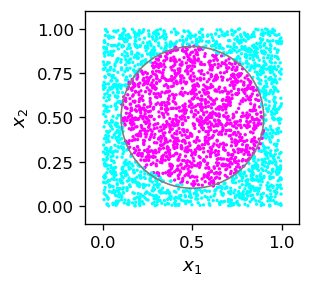

In [27]:
test=[] 

for k in range(3000):
    po=[np.random.random(),np.random.random()] 
    xt=func.feed_forward(arch_c,weights,po,ff=func.sig)   
    test.append([po[0],po[1],np.round(xt[len(arch_c)-1][0],0)])

tt=np.array(test)

fig=plt.figure(figsize=(2.3,2.3),dpi=120)

# drawing the circle
ax=fig.add_subplot(1,1,1)
circ=plt.Circle((0.5,0.5), radius=.4, color='gray', fill=False)
ax.add_patch(circ)

plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(tt[:,0],tt[:,1],c=tt[:,2],
            s=1,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

Wytrenowana sieć wygląda następująco: 

In [28]:
fnet=draw.plot_net_w(arch_c,weights,.1)

In [29]:
# fnet.savefig('images/cir3.png', bbox_inches='tight')

```{note}
To fascynujące, że nauczyliśmy sieć rozpoznawać, czy punkt znajduje się w okręgu, a nie ma ona żadnego pojęcia o geometrii, odległości euklidesowej, równaniu okręgu itp. Sieć właśnie nauczyła się „empirycznie”, jak postępować, za pomocą próbki szkoleniowej!
```

```{note}
Wynik przedstawiony na rysunku jest całkiem niezły, może z wyjątkiem, jak zwykle, punktów blisko granicy. Biorąc pod uwagę naszą dyskusję w rozdz. {ref}`more-lab`, w którym wyznaczyliśmy wagi sieci z trzema warstwami neuronów na podstawie rozważań geometrycznych, jakość prezentowanego wyniku jest oszałamiająca. Nie widzimy żadnych prostych boków wielokąta, ale ładnie zaokrągloną granicę. Dalsza poprawa wyniku wymagałaby większej liczebności próbki szkoleniowej i dłuższego treningu, co jest czasochłonne.

```

```{admonition} Lokalne minima
:class: important

Wspomnieliśmy wcześniej o pojawianiu się minimów lokalnych w optymalizacji wielowymiarowej jako o potencjalnym problemie. Na poniższym rysunku pokazujemy trzy różne wyniki kodu backprop dla naszego klasyfikatora punktów w okręgu. Zauważamy, że każdy z nich ma radykalnie inny zestaw optymalnych wag, podczas gdy spawdzenie na próbce testowej jest, przynajmniej na oko, równie dobre dla każdego przypadku. To pokazuje, że optymalizacja backprop prowadzi, zgodnie z przewidywaniami, do różnych minimów lokalnych. Jednak każde z nich działa wystarczająco i równie dobrze. To jest właśnie powód, dla którego algorytm backprop można wykorzystać w praktycznych problemach: istnieją miliony lokalnych minimów, ale to naprawdę nie ma znaczenia!

```

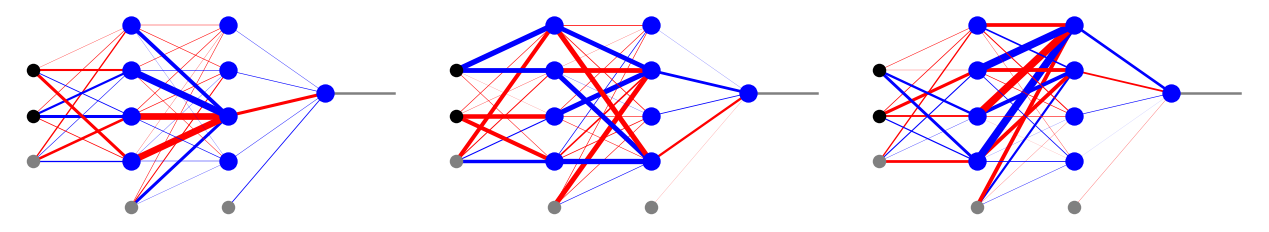

In [32]:
Image(filename="images/cir1-3.png",width=800)

## Ogólne uwagi

Należy poczynić kilka istotnych i ogólnych obserwacji:

```{note}

- Uczenie nadzorowane zajmuje bardzo dużo czasu, ale użycie wytrenowanej sieci trwa mgnienie oka. Asymetria wynika z prostego faktu, że optymalizacja wieloparametrowa wymaga bardzo wielu wywołań funkcji (tutaj **feed-forward**) i obliczneia pochodnych w wielu rundach (użyliśmy 1000 rund dla przykładu okręgu), ale użycie sieci dla przypadku jednego punktu wymaga tylko jednego wywołania funkcji.

- Klasyfikator wyszkolony algorytmem backprop może działać niedokładnie dla punktów w pobliżu linii granicznych. Środkiem zaradczym jest dłuższe trenowanie i/lub zwiększenie
liczebności próbki szkoleniowej, w szczególności w pobliżu granicy.

- Jednak zbyt długa nauka na tej samej próbce treningowej nie ma sensu, ponieważ w pewnym momencie dokładność przestaje się poprawiać.

- Lokalne minima są powszecjne, ale w żadnym wypadku nie stanowi to przeszkody w stosowaniu algorytmu. To ważna praktyczna cecha.

- Można stosować różne ulepszenia metody najstromszego spadku lub zupełnie inne metody minimalizacji (patrz ćwiczenia). Mogą one znacznie zwiększyć wydajność algorytmu.

- Cofając się z aktualizacją wag w kolejnych warstwach, można wprowadzić współczynnik zwiększający uaktualnianie (patrz ćwiczenia). To pomaga w wydajności.

- Wreszcie, inne funkcje aktywacji mogą być używane do poprawy wydajności (patrz kolejne wykłady).
```

## Ćwiczenia

```{admonition} $~$
:class: warning

1. Udowodnij (analitycznie), obliczając pochodną, że $ \sigma '(s) = \sigma (s) [1- \sigma (s)]$. Pokaż, że sigmoid jest **jedyną** funkcją z tą właściwością.

2. Wyprowadź jawnie wzory algorytmu backprop dla sieci z jedną i dwiema warstwami pośrednimi. Zwróć uwagę na pojawiającą się prawidłowość (powtarzalność) i udowodnij ogólne wzory z wykładu dla dowolnej liczby warstw pośrednich.

3. Zmodyfikuj przykład z wykładu dla klasyfikatora punktów w okręgu dla:

    - półkola;
    - dwóch rozłącznych okręgów;
    - pierścienia;
    - dowolnego z twoich ulubionych kształtów.

4. Powtórz 3, eksperymentując z liczbą warstw i neuronów, ale pamiętaj, że duża ich liczba wydłuża czas obliczeń i niekoniecznie poprawia wynik. Uszereguj każdy przypadek według liczby błędnie sklasyfikowanych punktów w próbce testowej. Znajdź optymalną/praktyczną architekturę dla każdego z rozważanych obszarów.

4. Jeśli sieć ma dużo neuronów i połączeń, przez każdą synapsę przepływa mało sygnału, stąd sieć jest odporna na niewielkie przypadkowe uszkodzenia. Tak dzieje się w naszym mózgu, który jest nieustannie „uszkadzany” (promienie kosmiczne, alkohol,...). Poza tym taką sieć po zniszczeniu można (już przy mniejszej liczbie połączeń) dodatkowo doszkolić. Weź wytrenowaną sieć z problemu 3. i usuń jedno z jej **słabych** połączeń (najpierw znajdź je, sprawdzając wagi), zmieniając odpowiednią wagę na 0. Przetestuj taką uszkodzoną sieć na próbce testowej i wyciągnij wnioski.

5. **Skalowanie wag w propagacji wstecznej.**
Wadą zastosowania sigmoidu w algorytmie backprop jest bardzo powolna aktualizacja wag w warstwach odległych od warstwy wyjściowej (im bliżej początku sieci, tym wolniej). Remedium jest tutaj przeskalowanie wag, gdzie szybkość uczenia się warstw, licząc od tyłu, jest sukcesywnie zwiększana o pewien współczynnik. Pamiętamy, że kolejne pochodne wnoszą do szybkości aktualizacji współczynniki postaci $ \sigma '(s) = \sigma (s) [1- \sigma (s)] = y (1-y) $, gdzie $ y $ wynosi w zakresie $ (0, 1) $. Zatem wartość $ y (1-y $ nie może przekraczać 1/4, a w kolejnych warstwach (licząc od tyłu) czynnika $ [y (1-y] ^ n \le 1/4 ^ n$).
Aby zapobiec temu „kurczeniu się”, wskaźnik uczenia się można przemnażać przez współczynniki kompensacyjne $4 ^ n: 4, 16, 64, 256, ... $. Kolejny argument heurystyczny {cite}`rigler1991` sugeruje jeszcze szybciej rosnące czynniki  postaci $6^n$:$6,36,216,1296,...$

    - Wprowadź powyższe dwie receptury do kodu backprop.

    - Sprawdź, czy rzeczywiście poprawiają wydajność algorytmu dla głębszych sieci, na przykład dla klasyfikatora punktów okręgu itp.

    - W celu oceny wydajności wykonaj pomiar czasu wykonania (np. za pomocą pakietu biblioteki Python **time**).

6. **Najstromsze spadek.**
Zastosowana w wykładzie metoda najstromszego spadku do wyznaczania minimum funkcji wielu zmiennych zależy od gradientu lokalnego. Istnieją znacznie lepsze podejścia, które zapewniają szybszą zbieżność do (lokalnego) minimum. Jednym z nich jest przepis [Barzilai-Borwein](https://en.wikipedia.org/wiki/Gradient_descent) wyjaśniony poniżej. Zaimplementuj tę metodę w algorytmie wstecznej propagacji. Wektory $x$ w przestrzeni $n$-wymiarowej są aktualizowane w kolejnych iteracjach jako $ x^{(m + 1)} = x^{(m)} - \gamma_m \nabla F (x^{(m)} )$,
gdzie $m$ numeruje iterację, a szybkość uczenia się zależy od zachowania w dwóch (bieżącym i poprzednim) punktach:

$$ \gamma _ {m} = \frac {\left | \left (x^{(m)}-x^{(m-1)} \right) \cdot
\left [\nabla F (x^{(m)}) - \nabla F (x^{(m-1)}) \right] \right |}
{\left \| \nabla F (x^{(m)}) - \nabla F (x^{(m-1)}) \right \| ^ {2}}.
$$
    
```